# Example of the Basic HMM Approach

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../hidden_regime')
import hidden_regime as hr
from hidden_regime import HiddenMarkovModel, HMMConfig

In [3]:
TICKER = 'SPY'
NUM_STATES = 4
START_DATE = '2023-01-01'
END_DATE = '2025-09-02'
RANDOM_SEED = 4242

In [4]:
data = hr.load_stock_data(TICKER, START_DATE, END_DATE)

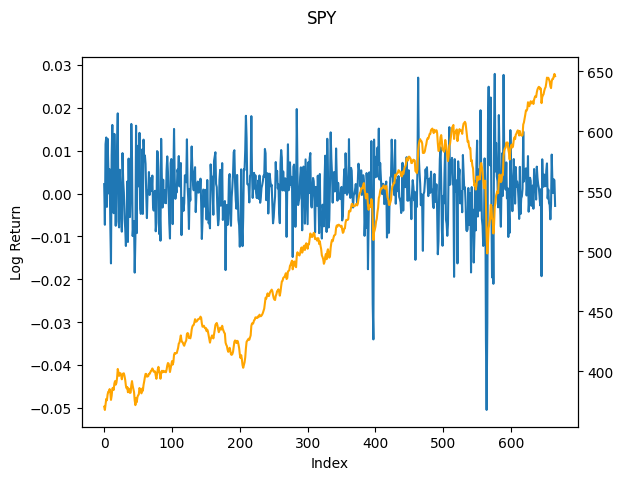

In [5]:
fig = plt.figure()
ax = data.log_return.plot()
ax.set_ylabel('Log Return')
ax.set_xlabel('Index')
ax2 = ax.twinx()
_ = data.price.plot(ax=ax2, color='orange')
_ = fig.suptitle(TICKER)

In [6]:
config = HMMConfig(
    n_states=NUM_STATES,
    max_iterations=100,
    tolerance=1e-6,
    initialization_method='kmeans',
    random_seed=RANDOM_SEED
)

In [7]:
hmm = HiddenMarkovModel(config=config)

/mnt/c/Workspace/hidden-regime/hidden_regime/models/base_hmm.py:80: UserWarning: Config n_states (4) doesn't match constructor n_states (3). Using constructor value.
  warnings.warn(


In [8]:
hmm.fit(data.log_return, verbose=True)

Training 4-state HMM on 666 observations
Max iterations: 100, Tolerance: 1e-06
Iteration 0: Log-likelihood = 2353.1605, Improvement = inf
Iteration 10: Log-likelihood = 2378.9767, Improvement = 0.560107
Iteration 20: Log-likelihood = 2387.6005, Improvement = 1.303018
Iteration 30: Log-likelihood = 2401.8420, Improvement = 1.102195
Iteration 40: Log-likelihood = 2408.7940, Improvement = 0.389247
Iteration 50: Log-likelihood = 2410.8976, Improvement = 0.244187
Iteration 60: Log-likelihood = 2415.5425, Improvement = 0.398631
Iteration 70: Log-likelihood = 2416.6689, Improvement = 0.002205
Iteration 80: Log-likelihood = 2416.5386, Improvement = -0.015043
Iteration 90: Log-likelihood = 2416.4197, Improvement = -0.009278
Training completed in 39.77s
Final log-likelihood: 2416.3565


HiddenMarkovModel(n_states=4, fitted=True, log_likelihood=2416.36)

In [9]:
hmm.initial_probs_

array([1.84836101e-06, 9.99994488e-01, 2.45249180e-06, 1.21141002e-06])

In [10]:
for i in range(NUM_STATES):
    mean, std = hmm.emission_params_[i]
    print(f"     State {i}: mean={mean:.4f}, std={std:.4f}")

     State 0: mean=0.0016, std=0.0039
     State 1: mean=-0.0051, std=0.0058
     State 2: mean=0.0064, std=0.0062
     State 3: mean=-0.0038, std=0.0218


In [11]:
hmm.transition_matrix_

array([[8.99940265e-01, 1.00059327e-01, 4.01839722e-07, 6.31218812e-09],
       [6.08580163e-05, 6.74059139e-01, 3.25879985e-01, 1.80498651e-08],
       [2.00929021e-01, 1.55516082e-01, 6.23004424e-01, 2.05504730e-02],
       [7.84515651e-08, 6.56275508e-08, 1.52114218e-01, 8.47885638e-01]])

In [12]:
predicted_states = hmm.predict(data.log_return)
state_probabilities = hmm.predict_proba(data.log_return)

In [13]:
price = data.set_index(data.date).price

In [14]:
predicted_state = pd.Series(
    index=data.date, 
    data=predicted_states, 
    name=f'{TICKER}_Predicted_States')

state_probability = pd.DataFrame(
    index=data.date, 
    data=state_probabilities)

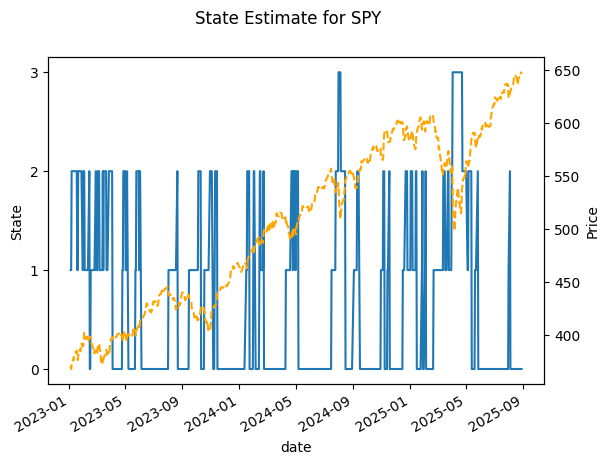

In [15]:
fig = plt.figure()
ax = predicted_state.plot.line()
plt.yticks(list(range(NUM_STATES)))
ax.set_ylabel('State')
ax2 = ax.twinx()
_ = price.plot(ax=ax2, color='orange', style='--')
ax2.set_ylabel('Price')
_ = fig.suptitle(f'State Estimate for {TICKER}')

<Figure size 640x480 with 0 Axes>

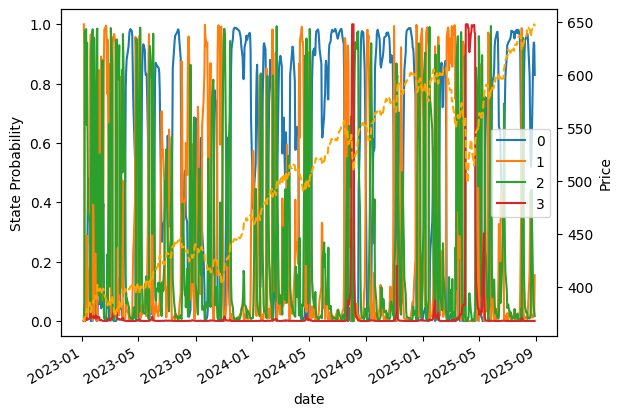

In [16]:
fig = plt.figure()
ax = state_probability.plot.line()
ax.set_ylabel('State Probability')
ax2 = ax.twinx()
_ = price.plot(ax=ax2, color='orange', style='--')
ax2.set_ylabel('Price')
_ = fig.suptitle(f'State Probability Estimate for {TICKER}')